**Imports**

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import zlib
import pickle
import os
import matplotlib.pyplot as plt
from itertools import combinations
import sys
import math
from collections import Counter
from scipy.stats import zscore


compressed_sizes = {}


**Load dataset**

In [2]:
def load_dataset(file_path):
    df = pd.read_csv(file_path, sep="::", engine="python", names=["user_id", "item_id", "rating", "timestamp", "normalized_rating"])
    return df

**Dictionary with pre-computed values**

In [3]:
def compute_compressed_sizes(user_ratings):
    
    for user, ratings in user_ratings.items():
        u_string = "".join(f"{k}:{v} " for k, v in sorted(ratings.items()))
        compressed_sizes[u_string] = len(zlib.compress(u_string.encode()))
    
    return compressed_sizes


**Similarities**

In [4]:
def linear_similarity(ratings_u, ratings_v):
    common_items = set(ratings_u.keys()).intersection(set(ratings_v.keys()))
    if not common_items:
        return 0  # If no common items, similarity is 0

    diff_sum = sum(abs(ratings_u[i] - ratings_v[i]) for i in common_items)
    ls_value = 1 - (diff_sum / len(common_items))
    return max(0, ls_value)  # Ensure similarity is non-negative

# Compression Similarity with precomputed sizes
def compression_similarity(ratings_u, ratings_v):
    u_string = "".join(f"{k}:{v} " for k, v in sorted(ratings_u.items()))
    v_string = "".join(f"{k}:{v} " for k, v in sorted(ratings_v.items()))
    c_uv = len(zlib.compress((u_string + v_string).encode()))
    c_u = compressed_sizes[u_string]
    c_v = compressed_sizes[v_string]
    return 1 - (c_uv - min(c_u, c_v)) / max(c_u, c_v)

# Kolmogorov Similarity with precomputed sizes
def kolmogorov_similarity(ratings_u, ratings_v):
    #ordena a priori os ratings dado por cada user
    u_string = "".join(f"{k}:{v} " for k, v in sorted(ratings_u.items()))
    v_string = "".join(f"{k}:{v} " for k, v in sorted(ratings_v.items()))
    c_u = compressed_sizes[u_string]
    c_v = compressed_sizes[v_string]
    return 1 / (1 + abs(c_u - c_v))

import math

def jaccard_similarity(ratings_u, ratings_v):
    """
    Computes the Jaccard Similarity between two users' rating sets.
    It considers only the presence of ratings, not their values.
    """
    items_u = set(ratings_u.keys())
    items_v = set(ratings_v.keys())
    
    intersection = items_u.intersection(items_v)
    union = items_u.union(items_v)
    
    if not union:
        return 0  # Avoid division by zero
    
    return len(intersection) / len(union)

def cosine_similarity(ratings_u, ratings_v):
    """
    Computes the Cosine Similarity between two users' rating vectors.
    """
    common_items = set(ratings_u.keys()).intersection(set(ratings_v.keys()))
    
    if not common_items:
        return 0  # If no common items, similarity is 0

    # Compute dot product and magnitudes
    dot_product = sum(ratings_u[i] * ratings_v[i] for i in common_items)
    magnitude_u = math.sqrt(sum(ratings_u[i] ** 2 for i in ratings_u))
    magnitude_v = math.sqrt(sum(ratings_v[i] ** 2 for i in ratings_v))
    
    if magnitude_u == 0 or magnitude_v == 0:
        return 0  # Avoid division by zero
    
    return dot_product / (magnitude_u * magnitude_v)



**Simlarity Matrix and graph**

In [5]:
# Compute user similarity matrix and construct graph (with precomputed sizes)
def compute_similarity_matrix(user_ratings, similarity_measure, compressed_sizes, similarity_threshold):
    similarity_graph = nx.Graph()

    # Step 1: Add all users as nodes (ensures isolated users are included)
    similarity_graph.add_nodes_from(user_ratings.keys())

    # Step 2: Compute pairwise similarities and add edges if similarity > 0.99
    for (u, v) in combinations(user_ratings.keys(), 2):
        sim = similarity_measure(user_ratings[u], user_ratings[v])
        if sim > similarity_threshold:
            similarity_graph.add_edge(u, v, weight=sim)

    return similarity_graph

# Detect user clusters from similarity graph
def detect_groups(similarity_graph,min_cluster_size):
    """ Detect user clusters from similarity graph and assign small clusters to a complementary cluster. """
    clusters = list(nx.connected_components(similarity_graph))
    complementary_cluster = set()
    filtered_clusters = []

    for cluster in clusters:
        if len(cluster) < min_cluster_size:
            complementary_cluster.update(cluster)  # Add small clusters to the complementary cluster
        else:
            filtered_clusters.append(cluster)  # Keep large clusters as they are

    if complementary_cluster:
        filtered_clusters.append(complementary_cluster)  # Add complementary cluster if it has users

    filtered_cluster_sizes = [len(group) for group in filtered_clusters]
    print("Number of clusters: ", len(filtered_clusters))
    print("complementary_cluster: ", len(complementary_cluster))
    mean_size = np.mean(filtered_cluster_sizes)
    std_size = np.std(filtered_cluster_sizes)
    z_score = (len(complementary_cluster) - mean_size) / std_size if std_size > 0 else float('inf')
    print("z_score: ", z_score)

    return filtered_clusters

**Reputation-based intra-clustering**

In [6]:
def compute_cluster_ratings(df, user_groups):
    """ Compute initial ratings per cluster based only on the items rated by at least 5 users in the cluster. """
    cluster_item_ratings = {}

    # Iterate through each user cluster
    for cluster_idx, user_set in enumerate(user_groups, start=1): 
        cluster_df = df[df["user_id"].isin(user_set)]  # Filter dataset to only include users in the cluster
        item_rating_counts = cluster_df["item_id"].value_counts()  # Count ratings per item
        
        # Filter items that have at least x ratings
        #TODO
        valid_items = item_rating_counts[item_rating_counts >= 1].index  

        # Compute the mean only for valid items
        filtered_avg_ratings = cluster_df[cluster_df["item_id"].isin(valid_items)].groupby("item_id")["normalized_rating"].mean().to_dict()

        cluster_item_ratings[cluster_idx] = filtered_avg_ratings

    return cluster_item_ratings

def refine_cluster_ratings(df, user_groups, cluster_item_ratings, threshold):
    """Refine cluster ratings by filtering out extreme user ratings until convergence."""
    refined_ratings = {}
    total_ratings_count = 0
    total_filtered_count = 0

    # Iterate through each user cluster
    for cluster_idx, user_set in enumerate(user_groups, start=1):
        if cluster_idx not in cluster_item_ratings:
            continue  # Skip clusters without precomputed ratings

        cluster_df = df[df["user_id"].isin(user_set)]  # Filter dataset to only include users in the cluster
        final_ratings = cluster_item_ratings[cluster_idx].copy()

        for item, initial_avg in final_ratings.items():
            item_ratings = cluster_df[cluster_df["item_id"] == item][["user_id", "normalized_rating"]].copy()

            total_ratings = len(item_ratings)
            total_ratings_count += total_ratings
            previous_avg = None
            current_avg = initial_avg
            filtered_count = 0

            while previous_avg is None or abs(current_avg - previous_avg) > 1e-6:  # Iterate until convergence
                previous_avg = current_avg
                lower_bound = current_avg - threshold
                upper_bound = current_avg + threshold

                # Identify ratings to be ignored in calculation but not deleted
                valid_ratings = item_ratings[(item_ratings["normalized_rating"] >= lower_bound) & 
                                             (item_ratings["normalized_rating"] <= upper_bound)]
                filtered_count = total_ratings - len(valid_ratings)
                total_filtered_count += filtered_count

                if valid_ratings.empty:
                    break  # Stop if no valid ratings remain

                new_avg = valid_ratings["normalized_rating"].mean()
                current_avg = new_avg

            final_ratings[item] = current_avg

        refined_ratings[cluster_idx] = final_ratings

    print(f"Total Ratings: {total_ratings_count} | Total Filtered: {total_filtered_count}")
    return refined_ratings

def compute_weighted_average_cluster_ratings(cluster_item_ratings, user_groups):
    """Compute weighted average ratings for each item across clusters using cluster size as weight."""
    item_weighted_sums = {}
    item_total_weights = {}
    
    # Iterate over clusters and their item ratings
    for cluster_idx, item_ratings in cluster_item_ratings.items():
        cluster_size = len(user_groups[cluster_idx - 1])  # Cluster index is 1-based, user_groups is 0-based
        
        for item, rating in item_ratings.items():
            #intialize the item if it does not exist
            if item not in item_weighted_sums:
                item_weighted_sums[item] = 0
                item_total_weights[item] = 0
            
            # Add weighted contribution
            item_weighted_sums[item] += rating * cluster_size
            item_total_weights[item] += cluster_size
    
    # Compute weighted averages and round to the nearest decimal place
    weighted_averages = {item: round(item_weighted_sums[item] / item_total_weights[item], 1) for item in item_weighted_sums}
    
    return weighted_averages


def round_ratings_to_one_decimal(new_ratings):
    """Round all item ratings to the nearest one decimal place."""
    return {cluster: {item: round(rating, 1) for item, rating in items.items()} for cluster, items in new_ratings.items()}




**Plot Generation**

In [22]:
def plot_top_3_clusters(cluster_ratings):
    """Plot a bar chart showing the rating distribution for the three largest clusters with bins."""
    # Sort clusters by size (number of items rated) in descending order
    top_clusters = sorted(cluster_ratings.keys(), key=lambda c: len(cluster_ratings[c]), reverse=True)[:3]

    # Define bins from 0.1 to 1.0 (inclusive)
    bins = np.arange(0.05, 1.05, 0.1)  # Bin centers
    bin_labels = [round(b, 1) for b in np.arange(0.1, 1.1, 0.1)]  # Labels for x-axis

    plt.figure(figsize=(12, 5))

    # Adjust vertical position offset for each cluster
    vertical_offset = 0.0

    for cluster in top_clusters:
        # Flatten ratings in the cluster
        ratings = list(cluster_ratings[cluster].values())

        # Digitize ratings into bins
        bin_indices = np.digitize(ratings, bins, right=True)
        bin_counts = Counter(bin_indices)

        # Create an aligned count array
        counts = [bin_counts[i + 1] if i + 1 in bin_counts else 0 for i in range(len(bin_labels))]

        # Plot the bar chart for the cluster, adjusting the position of the bars
        plt.bar(bin_labels, counts, width=0.07, alpha=0.6, label=f'Cluster {cluster}', bottom=vertical_offset)

        # Add value labels with a vertical offset for readability
        for i, count in enumerate(counts):
            if count > 0:
                plt.text(bin_labels[i], count + vertical_offset + 0.5, str(count), ha='center', fontsize=10)

        # Update the vertical offset for the next cluster
        vertical_offset += max(counts) + 2  # Adjust the offset based on the max count in the current cluster

    plt.xlabel("Item Rating (Binned from 0.1 to 1.0)")
    plt.ylabel("Number of Items")
    plt.title("Cosine 0.6 | reputation threshold 0.95")
    plt.xticks(bin_labels)
    plt.legend()
    plt.show()



def plot_weighted_average_distribution(weighted_average_dict):
    """Plot a bar chart showing the distribution of weighted average ratings with bins from 0.1 to 1.0."""
    # Flatten weighted averages
    ratings = list(weighted_average_dict.values())

    # Define bins from 0.1 to 1.0
    bins = np.arange(0.05, 1.05, 0.1)  # Bin centers
    bin_labels = [round(b, 1) for b in np.arange(0.1, 1.1, 0.1)]  # Labels for x-axis

    # Digitize ratings into bins
    bin_indices = np.digitize(ratings, bins, right=True)
    bin_counts = Counter(bin_indices)

    # Create an aligned count array
    counts = [bin_counts[i + 1] if i + 1 in bin_counts else 0 for i in range(len(bin_labels))]

    # Plot the bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(bin_labels, counts, width=0.07, color='blue', alpha=0.7)

    # Add value labels
    for i, count in enumerate(counts):
        if count > 0:
            plt.text(bin_labels[i], count + 0.5, str(count), ha='center', fontsize=10)

    plt.xlabel("Weighted Average Rating (Binned from 0.1 to 1.0)")
    plt.ylabel("Number of Items")
    plt.title("Distribution of Weighted Average Ratings (Binned)")
    plt.xticks(bin_labels)
    plt.show()

**Main function**

In [8]:

# Main execution
file_path = "/home/martim/Desktop/tese/datasets/ml-100k/sorted_normalized_rating_movielns_100k.dat"
df = load_dataset(file_path)

# Prepare user ratings
user_ratings = {user: dict(zip(group["item_id"], group["normalized_rating"])) for user, group in df.groupby("user_id")}

print("\nuser_ratings: ", user_ratings)
# Compute or load compressed sizes
compressed_sizes = compute_compressed_sizes(user_ratings)
print("comprimido")


user_ratings:  {1: {61: 0.8, 189: 0.6, 33: 0.8, 160: 0.8, 20: 0.8, 202: 1.0, 171: 1.0, 265: 0.8, 155: 0.4, 117: 0.6, 47: 0.8, 222: 0.8, 253: 1.0, 113: 1.0, 227: 0.8, 17: 0.6, 90: 0.8, 64: 1.0, 92: 0.6, 228: 1.0, 266: 0.2, 121: 0.8, 114: 1.0, 132: 0.8, 74: 0.2, 134: 0.8, 98: 0.8, 186: 0.8, 221: 1.0, 84: 0.8, 31: 0.6, 70: 0.6, 60: 1.0, 177: 1.0, 27: 0.4, 260: 0.2, 145: 0.4, 174: 1.0, 159: 0.6, 82: 1.0, 56: 0.8, 272: 0.6, 80: 0.8, 229: 0.8, 140: 0.2, 225: 0.4, 235: 1.0, 120: 0.2, 125: 0.6, 215: 0.6, 6: 1.0, 104: 0.2, 49: 0.6, 206: 0.8, 76: 0.8, 72: 0.8, 185: 0.8, 96: 1.0, 213: 0.4, 233: 0.4, 258: 1.0, 81: 1.0, 78: 0.2, 212: 0.8, 143: 0.2, 151: 0.8, 51: 0.8, 175: 1.0, 107: 0.8, 218: 0.6, 209: 0.8, 259: 0.2, 108: 1.0, 262: 0.6, 12: 1.0, 14: 1.0, 97: 0.6, 44: 1.0, 53: 0.6, 163: 0.8, 210: 0.8, 184: 0.8, 157: 0.8, 201: 0.6, 150: 1.0, 183: 1.0, 248: 0.8, 208: 1.0, 128: 0.8, 242: 1.0, 148: 0.4, 112: 0.2, 193: 0.8, 264: 0.4, 219: 0.2, 232: 0.6, 236: 0.8, 252: 0.4, 200: 0.6, 180: 0.6, 250: 0.8, 8

**Clustering**

In [21]:
# Choose similarity measure: linear_similarity, compression_similarity, kolmogorov_similarity
similarity_graph = compute_similarity_matrix(user_ratings, cosine_similarity, compressed_sizes,0.6)

# Get threshold for complementary cluster
num_users = df["user_id"].nunique()
complementary_cluster_threshold = num_users * 0.005

# Detect user clusters from similarity graph
user_groups = detect_groups(similarity_graph, complementary_cluster_threshold)

# Print the number of detected clusters
print(f"User groups: {(user_groups)}")

print("number of user_groups: ", len(user_groups))

#count total number of elements in usergroups
total = 0
for group in user_groups:
    total += len(group)
print("total number of elements in usergroups: ", total)

#biggest user group, average size of user groups
biggest = 0
for group in user_groups:
    if len(group) > biggest:
        biggest = len(group)
print("biggest user group: ", biggest)

average = total / len(user_groups)
print("average size of user groups: ", average)





Number of clusters:  3
complementary_cluster:  837
z_score:  1.413716846806906
User groups: [{896, 130, 7, 648, 650, 524, 653, 398, 271, 655, 268, 18, 916, 405, 406, 151, 407, 537, 666, 276, 532, 416, 417, 804, 293, 932, 551, 682, 429, 301, 303, 561, 178, 435, 308, 694, 311, 312, 313, 59, 194, 450, 326, 457, 843, 716, 846, 85, 474, 90, 92, 94, 222, 864, 487, 234, 747, 618, 749, 363, 109, 880, 881, 378, 892}, {384, 258, 772, 143, 784, 529, 146, 787, 915, 281, 284, 926, 544, 801, 809, 170, 171, 812, 173, 47, 570, 827, 446, 574, 832, 451, 841, 587, 589, 724, 853, 856, 863, 611, 356, 100, 616, 489, 112, 752, 510}, {1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 91, 93, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 

**Ranking computation**


cluster_item_ratings:  {1: {1: 0.7927272727272727, 2: 0.6263157894736843, 3: 0.6, 4: 0.7035714285714285, 5: 0.6333333333333334, 6: 0.8, 7: 0.78, 8: 0.8227272727272728, 9: 0.8047619047619047, 10: 0.7875, 11: 0.8244897959183674, 12: 0.8759999999999999, 13: 0.6827586206896552, 14: 0.7913043478260869, 15: 0.7380952380952381, 16: 0.5599999999999999, 17: 0.6608695652173914, 18: 0.6666666666666666, 19: 0.5714285714285714, 20: 0.625, 21: 0.5333333333333333, 22: 0.8545454545454545, 23: 0.8047619047619047, 24: 0.6909090909090909, 25: 0.6339622641509435, 26: 0.6799999999999999, 27: 0.631578947368421, 28: 0.7892857142857144, 29: 0.48484848484848486, 30: 0.7692307692307693, 31: 0.7416666666666667, 32: 0.6900000000000001, 33: 0.6608695652173914, 34: 0.46666666666666673, 35: 0.3333333333333333, 36: 0.36, 37: 0.39999999999999997, 38: 0.54375, 39: 0.6571428571428571, 40: 0.46315789473684216, 41: 0.5666666666666667, 42: 0.7411764705882353, 43: 0.5625, 44: 0.6457142857142858, 45: 0.7999999999999999, 46: 

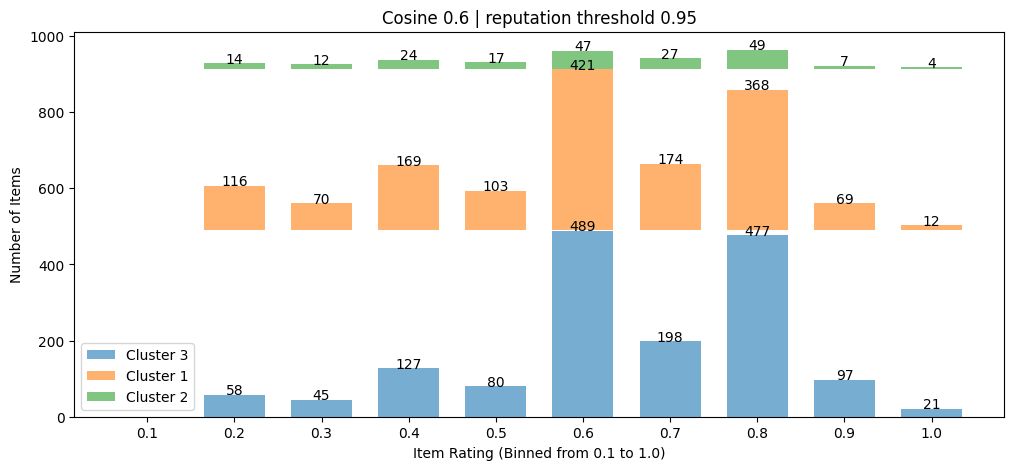

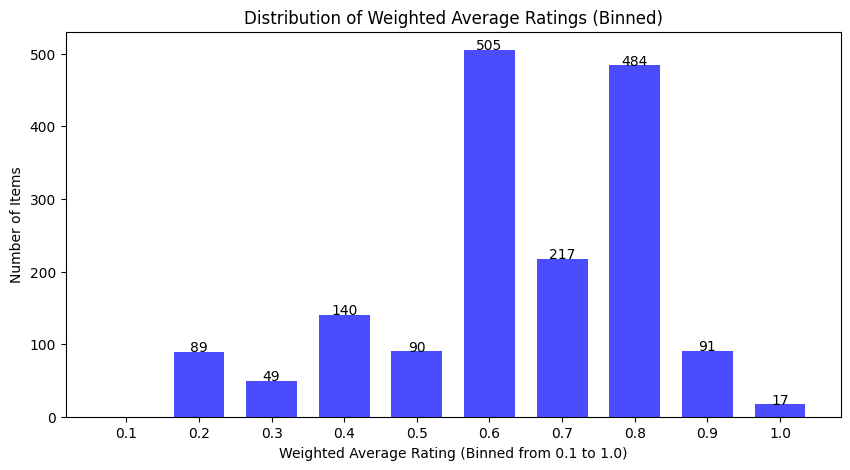

In [23]:
# Assuming user_groups is already defined
cluster_item_ratings = compute_cluster_ratings(df, user_groups)  # Step 1: Compute initial ratings

print("cluster_item_ratings: ", cluster_item_ratings)

refined_cluster_ratings = refine_cluster_ratings(df, user_groups, cluster_item_ratings, threshold=0.3)

weighted_average_dict = compute_weighted_average_cluster_ratings(refined_cluster_ratings, user_groups)

# round all clusters values 
rounded_ratings = round_ratings_to_one_decimal(refined_cluster_ratings)

print("rounded_ratings: ", rounded_ratings)
print("len(rounded_ratings): ", len(rounded_ratings))

plot_top_3_clusters(rounded_ratings)  # Use actual dictionary
plot_weighted_average_distribution(weighted_average_dict)  # Use actual computed weighted averages


